In [4]:
############################################## Dependency #############################################################################################
import cv2
import math
import os
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [5]:
############################################## Mediapipe Utils ########################################################################################
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_detection = mp.solutions.face_detection
mp_selfie_segmentation = mp.solutions.selfie_segmentation

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, 
                       max_num_hands=2, 
                       min_detection_confidence=0.2)

mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)


# Ambil daftar koneksi untuk Tesselation, Contours, dan Irises
connections = {
    "tesselation": (mp_face_mesh.FACEMESH_TESSELATION, 'cyan'),
    "contours": (mp_face_mesh.FACEMESH_CONTOURS, 'red'),
    "irises": (mp_face_mesh.FACEMESH_IRISES, 'magenta')
}

# Atur linewidth untuk setiap koneksi
linewidths = {
    "tesselation": 0.5,  # Lebih tipis
    "contours": 2.5,  # Medium
    "irises": 1.0  # Lebih tebal
}


In [6]:
############################################## Landmark Hand & Face ###################################################################################
def landmark_tangan(tangan):
    image_height, image_width, _ = tangan.shape
    list_hand = []
    
    img_copy = tangan.copy()
    results = hands.process(cv2.cvtColor(tangan, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
            list_poin = []
            mp_drawing.draw_landmarks(image = img_copy, landmark_list = hand_landmarks, connections = mp_hands.HAND_CONNECTIONS)
            for i in range(21):
                xc = int(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].x * image_width)
                yc = int(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].y * image_height)
                list_poin.append([xc, yc])
            list_hand.append(list_poin)
    return img_copy[:,:,::-1], list_hand

def landmark_wajah(face):
    annotated_image = face
    results = face_mesh.process(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    if not results.multi_face_landmarks:
        stat = 'gagal'
        return annotated_image, stat
    else:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(image=annotated_image,
                                      landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_TESSELATION,
                                      landmark_drawing_spec=None,
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
            mp_drawing.draw_landmarks(image=annotated_image,
                                      landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_CONTOURS,
                                      landmark_drawing_spec=None,
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
            mp_drawing.draw_landmarks(image=annotated_image,
                                      landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_IRISES,
                                      landmark_drawing_spec=None,
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())
        return annotated_image, results.multi_face_landmarks[0].landmark


def coordinate_landmark(wajah, landmark):
    # Load the image
    image = wajah.copy()
    poin_masking = landmark
    coordinates = np.array(poin_masking)
    mask = np.zeros(image.shape[:2], dtype=np.uint8)    
    cv2.fillPoly(mask, [coordinates], 1)    
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image


In [7]:
############################################## Koreksi Head Roll ######################################################################################
def correct_roll(image):
    image = image.copy()
    h, w, _ = image.shape
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    if not results.multi_face_landmarks:
        #print('Wajah tidak ditemukan!')
        return image
    for face_landmarks in results.multi_face_landmarks:
        left_eye = np.array([face_landmarks.landmark[33].x * w, face_landmarks.landmark[33].y * h])
        right_eye = np.array([face_landmarks.landmark[263].x * w, face_landmarks.landmark[263].y * h])
        dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
        angle = np.degrees(np.arctan2(dy, dx))
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1)
        corrected_image = cv2.warpAffine(image, M, (w, h))
        return corrected_image

def compute_yaw_angle(points):
    """ Hitung sudut yaw berdasarkan posisi hidung dan dagu """
    NOSE_IDX = 1  # Landmark hidung (pusat wajah)
    CHIN_IDX = 152  # Landmark dagu

    nose = points[NOSE_IDX]
    chin = points[CHIN_IDX]

    dx = chin[0] - nose[0]
    dz = chin[2] - nose[2]

    yaw_angle = np.degrees(np.arctan2(dx, dz))  # Sudut yaw dari sumbu Z
    return yaw_angle

def get_face_mesh_3d(image):
    """ Deteksi wajah dan ambil landmark 3D """
    h, w, _ = image.shape
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        print("Wajah tidak ditemukan!")
        return None, None

    face_landmarks = results.multi_face_landmarks[0].landmark
    points = np.array([(lm.x * w, lm.y * h, lm.z * w) for lm in face_landmarks])
    
    return points, face_landmarks

def convert_to_2d_xy(points):
    """ Konversi dari 3D ke 2D dengan menghilangkan koordinat Z """
    points_2d_xy = points[:, :2]  # Ambil hanya X dan Y
    return points_2d_xy

def save_2d_face_ori(points_2d, task, gambar_asli):
    filename = "face_2d_result_colored.png"
    h, w = gambar_asli.shape[:2]
    
    # Buat canvas putih dengan ukuran yang sama dengan gambar asli
    canvas = np.ones_like(gambar_asli, dtype=np.uint8) * 255

    # Warna untuk masing-masing koneksi
    color_map = {
        "tesselation": (255, 0, 0),  # Biru
        "contours": (0, 0, 255),     # Merah
        "irises": (0, 255, 255)      # Kuning
    }

    # Ketebalan garis
    linewidths = {
        "tesselation": 1,
        "contours": 2,
        "irises": 1
    }

    # Pastikan koordinat integer dan dalam batas gambar
    points_int = np.round(points_2d).astype(int)
    points_int[:, 0] = np.clip(points_int[:, 0], 0, w - 1)
    points_int[:, 1] = np.clip(points_int[:, 1], 0, h - 1)

    # Gambar koneksi antar titik
    for name, (conn, _) in connections.items():
        color = color_map.get(name, (0, 0, 0))
        thickness = linewidths.get(name, 1)
        for start, end in conn:
            pt1 = tuple(points_int[start])
            pt2 = tuple(points_int[end])
            cv2.line(canvas, pt1, pt2, color, thickness)

    # Gambar titik
    for x, y in points_int:
        cv2.circle(canvas, (x, y), 2, (0, 0, 0), -1)

    if task == 'simpan':
        cv2.imwrite(filename, canvas)
        print(f"Gambar 2D disimpan sebagai {filename}")
        return None
    else:
        return canvas

def rotate(points, angle, axis='z'):
    """ Rotasi titik 3D berdasarkan sumbu (z = roll, y = yaw, x = pitch) """
    angle_rad = np.radians(angle)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)

    if axis == 'z':  # Rotasi Roll
        R = np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ])
    elif axis == 'y':  # Rotasi Yaw
        R = np.array([
            [cos_a, 0, sin_a],
            [0, 1, 0],
            [-sin_a, 0, cos_a]
        ])
    elif axis == 'x':  # Rotasi Pitch
        R = np.array([
            [1, 0, 0],
            [0, cos_a, -sin_a],
            [0, sin_a, cos_a]
        ])
    else:
        raise ValueError("Axis harus 'z' (roll), 'y' (yaw), atau 'x' (pitch)")

    # Pusatkan titik sebelum rotasi
    center = np.mean(points, axis=0)
    rotated_points = np.dot(points - center, R.T) + center

    return rotated_points

In [8]:
############################################## Masking ################################################################################################
# hasil masking == ukuran asli image
def masking_img(images, f_poin, warna):
    warna_dict = {'putih': (255, 255, 255),
                  'hitam': (0, 0, 0),
                  'biru': (0, 0, 255),
                  'hijau': (0, 255, 0),
                  'merah': (255, 0, 0)}

    point_f = np.array(f_poin)
    l_face = coordinate_landmark(images, f_poin)
    l_faces = l_face.copy()
    im_bwf = cv2.fillPoly(l_faces, pts=[point_f], color=warna_dict[warna])
    return im_bwf


# hasil masking ==  ukuran wajah
def masking_img_(images, f_poin, warna):
    warna_dict = {'putih': (255, 255, 255),
                  'hitam': (0, 0, 0),
                  'biru': (0, 0, 255),
                  'hijau': (0, 255, 0),
                  'merah': (255, 0, 0)}

    point_f = np.array(f_poin)
    l_face = coordinate_landmark(images, f_poin)
    l_faces = l_face.copy()
    im_bwf = cv2.fillPoly(l_faces, pts=[point_f], color=warna_dict[warna])
    
    x, y, w, h = cv2.boundingRect(np.array(f_poin, dtype=np.int32))
    # Crop hasil sesuai bounding box
    hasil_crop = im_bwf[y:y+h, x:x+w]
    return hasil_crop

In [9]:
############################################## Blurring_hand ##########################################################################################
def blurring_hand(image):
    max_hands=2
    inpaint_radius=15 
    dilate_size=21
    method='NS'
    
    h, w, _ = image.shape
    
    # Init MediaPipe modules
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=max_hands)

    # Get segmentation mask
    results_seg = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    seg_mask = results_seg.segmentation_mask
    seg_binary = (seg_mask > 0.5).astype(np.uint8) * 255

    # Get hand polygons
    results_hand = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    mask_total = np.zeros((h,w), dtype=np.uint8)

    if results_hand.multi_hand_landmarks:
        for hand_landmarks in results_hand.multi_hand_landmarks:
            points = []
            for lm in hand_landmarks.landmark:
                px = int(lm.x * w)
                py = int(lm.y * h)
                points.append([px, py])
            hull = cv2.convexHull(np.array(points, dtype=np.int32))

            mask_hand = np.zeros((h,w), dtype=np.uint8)
            cv2.fillPoly(mask_hand, [hull], 255)

            # Intersect dengan segmentasi selfie
            hand_only = cv2.bitwise_and(seg_binary, seg_binary, mask=mask_hand)
            mask_total = cv2.bitwise_or(mask_total, hand_only)
    else:
        # Kalau tidak terdeteksi tangan, return image original
        return image

    # Dilate supaya benar-benar menutup area jari
    kernel = np.ones((dilate_size,dilate_size), np.uint8)
    mask_total = cv2.dilate(mask_total, kernel, iterations=1)

    # Inpaint
    flag = cv2.INPAINT_NS if method == 'NS' else cv2.INPAINT_TELEA
    result = cv2.inpaint(image, mask_total, inpaintRadius=inpaint_radius, flags=flag)
    return result

def masking_tangan_canvas_hitam(image, warna='merah', max_hands=2, dilate_size=21):
    warna_dict = {'putih': (255, 255, 255),
                  'hitam': (0, 0, 0),
                  'biru': (0, 0, 255),
                  'hijau': (0, 255, 0),
                  'merah': (255, 0, 0)}
    
    h, w, _ = image.shape

    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=max_hands)

    # Get segmentation mask
    results_seg = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    seg_mask = results_seg.segmentation_mask
    seg_binary = (seg_mask > 0.5).astype(np.uint8) * 255

    # Get hand polygons
    results_hand = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    mask_total = np.zeros((h,w), dtype=np.uint8)

    if results_hand.multi_hand_landmarks:
        for hand_landmarks in results_hand.multi_hand_landmarks:
            points = []
            for lm in hand_landmarks.landmark:
                px = int(lm.x * w)
                py = int(lm.y * h)
                points.append([px, py])
            hull = cv2.convexHull(np.array(points, dtype=np.int32))

            mask_hand = np.zeros((h,w), dtype=np.uint8)
            cv2.fillPoly(mask_hand, [hull], 255)

            hand_only = cv2.bitwise_and(seg_binary, seg_binary, mask=mask_hand)
            mask_total = cv2.bitwise_or(mask_total, hand_only)
    else:
        # Jika tidak ada tangan terdeteksi, kembalikan canvas hitam polos
        return np.zeros_like(image)

    # Pertebal mask agar menutup semua jari
    kernel = np.ones((dilate_size,dilate_size), np.uint8)
    mask_total = cv2.dilate(mask_total, kernel, iterations=1)

    # Buat canvas hitam lalu isi area mask dengan warna sesuai
    canvas = np.zeros_like(image)
    canvas[mask_total == 255] = warna_dict[warna]

    return canvas

In [10]:
############################################## Crop Wajah #############################################################################################
def potong_area(img, landmark_region):
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.array(landmark_region, dtype=np.int32), (255, 255, 255))
    hasil = cv2.bitwise_and(img, mask)
    return hasil

def potong_area_(img, landmark_region):
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.array(landmark_region, dtype=np.int32), (255, 255, 255))
    # Ambil area wajah saja
    hasil = cv2.bitwise_and(img, mask)
    # Hitung bounding box dari polygon landmark
    x, y, w, h = cv2.boundingRect(np.array(landmark_region, dtype=np.int32))
    # Crop hasil sesuai bounding box
    hasil_crop = hasil[y:y+h, x:x+w]
    return hasil_crop

In [11]:
############################################## Luas Wajah #############################################################################################
def luas_wajah(img):
    mask_putih = np.all(img == [255, 255, 255], axis=-1)
    luas_putih = np.sum(mask_putih)
    return luas_putih

In [12]:
############################################## Potong Tengah ##########################################################################################
def spatial_divide(img, xh):
    img_height, img_width, _ = img.shape
    cropped_image_l = img[0:img_height, 0:xh]
    cropped_image_r = img[0:img_height, xh:img_width]
    return cropped_image_l, cropped_image_r

In [13]:
############################################## Face Detection #########################################################################################
def crop_faces_from_image(img_input): #haarcascade
    # Load Haar cascade
    face_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_frontalface_default.xml')
    if not isinstance(img_input, np.ndarray):
        raise ValueError("Input harus berupa image array (numpy.ndarray)")
    gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=6, minSize=(40, 40))
    if len(faces) == 0:
        print("Tidak ada wajah terdeteksi.")
        return []
    cropped_faces = []
    for (x, y, w, h) in faces:
        face = img_input[y:y+h, x:x+w]
        cropped_faces.append(face)
    return cropped_faces


def crop_face_mediapipe(wajah):  #mediapipe
    image_rgb = cv2.cvtColor(wajah, cv2.COLOR_BGR2RGB)
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(image_rgb)
        if results.detections:
            for i, detection in enumerate(results.detections):
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = wajah.shape
                x, y = int(bboxC.xmin * iw), int(bboxC.ymin * ih)
                w, h = int(bboxC.width * iw), int(bboxC.height * ih)
                cropped_face = wajah[y:y+h, x:x+w]                
                cv2.rectangle(wajah, (x, y), (x + w, y + h), (0, 255, 0), 2)
        else:
            cropped_face = wajah
    return cropped_face

def crop_face_mtcnn(wajah): #mtcnn
    from mtcnn.mtcnn import MTCNN
    detector = MTCNN()    
    image = wajah
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(image_rgb)
    for i, face in enumerate(faces):
        x, y, w, h = face['box']
        # Tambahkan margin (opsional)
        margin = 0.05
        x1 = max(0, int(x - w * margin))
        y1 = max(0, int(y - h * margin))
        x2 = min(image.shape[1], int(x + w * (1 + margin)))
        y2 = min(image.shape[0], int(y + h * (1 + margin)))
        # Crop wajah
        face_crop = image[y1:y2, x1:x2]
    return face_crop

In [14]:
############################################## Combine Hands ##########################################################################################
def combine_hand(hand1, hand2):
    mask_tangan = np.any(hand1 != [0, 0, 0], axis=-1)
    hasil = hand2.copy()
    hasil[mask_tangan] = hand1[mask_tangan]
    return hasil

In [ ]:
############################################## Poin Landmark Wajah ####################################################################################
def list_poin_tangan(list_poin):
    poin_hand = [list_poin[0], list_poin[1], list_poin[2], list_poin[3], 
                    list_poin[4], list_poin[5], list_poin[6], list_poin[7], 
                    list_poin[8], list_poin[12], list_poin[16], 
                    list_poin[20], list_poin[19], list_poin[18],list_poin[17]]
    return poin_hand

def list_poin_wajah(dua_D):
    face_poin = [dua_D[152], dua_D[148], dua_D[176], dua_D[149], dua_D[150], dua_D[136], dua_D[172], dua_D[58], dua_D[132],
                  dua_D[93], dua_D[234], dua_D[127], dua_D[162], dua_D[21], dua_D[54], dua_D[103], dua_D[67], dua_D[109],
                  dua_D[10], dua_D[338], dua_D[297], dua_D[332], dua_D[284], dua_D[251], dua_D[389], dua_D[356], dua_D[454],
                  dua_D[323], dua_D[361], dua_D[288], dua_D[397], dua_D[365], dua_D[379], dua_D[378], dua_D[400], dua_D[377]
                 ]
    return face_poin

def titik_tengah_wajah():
    tengah = [ct[10], ct[151], ct[9], ct[8], ct[168], ct[197], ct[195], ct[5], ct[14], ct[1], ct[19], ct[2], ct[164], ct[0], ct[11], ct[12], ct[13]]
    return tengah

def wajah_kiri(dua_D):
    face_poin = [dua_D[152], dua_D[175], dua_D[199], dua_D[200], dua_D[18], dua_D[17], dua_D[16], dua_D[15], dua_D[14], dua_D[13], dua_D[12], 
                 dua_D[11], dua_D[0], dua_D[164], dua_D[2], dua_D[94], dua_D[4], dua_D[5], dua_D[195], dua_D[197], dua_D[6], dua_D[168], 
                 dua_D[8], dua_D[9], dua_D[151], dua_D[10], 
                 dua_D[109], dua_D[67], dua_D[103], dua_D[54], dua_D[21], dua_D[162], dua_D[127], dua_D[234], dua_D[93], dua_D[132], dua_D[58], 
                 dua_D[172], dua_D[136], dua_D[150], dua_D[149], dua_D[176], dua_D[148]
                 ]
    return face_poin

def wajah_kanan(dua_D):
    face_poin = [dua_D[152], dua_D[175], dua_D[199], dua_D[200], dua_D[18], dua_D[17], dua_D[16], dua_D[15], dua_D[14], dua_D[13], dua_D[12], 
                 dua_D[11], dua_D[0], dua_D[164], dua_D[2], dua_D[94], dua_D[4], dua_D[5], dua_D[195], dua_D[197], dua_D[6], dua_D[168], 
                 dua_D[8], dua_D[9], dua_D[151], dua_D[10], 
                 dua_D[338], dua_D[297], dua_D[332], dua_D[284], dua_D[251], dua_D[389], dua_D[356], dua_D[454], dua_D[323], dua_D[361], 
                 dua_D[288], dua_D[397], dua_D[365], dua_D[379], dua_D[378], dua_D[400], dua_D[377] 
                 ]
    return face_poin

def warp_poinsss(point): #poin warping baru (x lurus)
    poin = point.copy()
    xp, yp = poin[13]
    poin[:26] = [(xp, y) for (_, y) in poin[:26]]
    return poin

def warp_poin(point, yaw): #poin warping baru (x lurus)
    poin = point
    yaw = abs(yaw)
    if yaw < 10:
        xp, yp = poin[13]
    else:
        xp, yp = poin[22]
    poin[:26] = [(xp, y) for (_, y) in poin[:26]]
    return poin

In [16]:
############################################## Warping Wajah ke Warp Poin #############################################################################
def images_warping(data_wajah, data_landmark_src, data_landmark_dst):
    im = data_wajah
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    src_landmarks = data_landmark_src  # bentuk (N, 2)
    dst_landmarks = data_landmark_dst  # bentuk (N, 2)
    
    image_shape = im_rgb.shape
    height, width = image_shape[:2]
    
    # Normalisasi koordinat ke range image (jika perlu)
    # Misal: src_landmarks dalam piksel, langsung dipakai
    # Tapi jika dalam range [0,1], kalikan dulu
    # src_landmarks *= width
    # dst_landmarks *= width
    
    tform = PiecewiseAffineTransform()
    tform.estimate(dst_landmarks, src_landmarks)  # dari target ke source
    
    warped = warp(im_rgb, tform, output_shape=(height, width))
    warped = (warped * 255).astype(np.uint8)
    return warped

In [17]:
############################################## Show Image #############################################################################################
def show_img(img):
    plt.title('Result')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def show_images_grid(image_list, figsize=(12, 12)):
    num_images = len(image_list)
    max_cols = 6
    cols = min(max_cols, num_images)
    rows = math.ceil(num_images / cols)

    total_slots = rows * cols
    placeholder = np.ones((100, 100, 3), dtype=np.uint8) * 255  # putih
    while len(image_list) < total_slots:
        image_list.append((placeholder, None))
    image_list = image_list[:total_slots]

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.subplots_adjust(bottom=0.05)

    for ax, (img, color) in zip(axs, image_list):
        ax.axis('off')
        if color:
            ax.imshow(cv2.cvtColor(img, color))
        else:
            ax.imshow(img)
    plt.show()

def show_images_grid_mini(image_list, figsize=(6, 6)):
    num_images = len(image_list)
    max_cols = 6
    cols = min(max_cols, num_images)
    rows = math.ceil(num_images / cols)

    total_slots = rows * cols
    placeholder = np.ones((100, 100, 3), dtype=np.uint8) * 255  # putih
    while len(image_list) < total_slots:
        image_list.append((placeholder, None))
    image_list = image_list[:total_slots]

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.subplots_adjust(bottom=0.2)

    for ax, (img, color) in zip(axs, image_list):
        ax.axis('off')
        if color:
            ax.imshow(cv2.cvtColor(img, color))
        else:
            ax.imshow(img)
    plt.show()


In [18]:
############################################## Fig. Function ##########################################################################################
def before_after(emotion_before, emotion_after, img_path):
    import plotly.graph_objects as go
    
    # List label (harus sama antara before dan after)
    labels = list(emotion_before.keys())
    
    # Nilai before dan after dalam urutan yang sama
    before_values = [emotion_before[label] for label in labels]
    after_values = [emotion_after[label] for label in labels]
    
    # Membuat plot horizontal
    fig = go.Figure(data=[
        go.Bar(name='After Frontalization', y=labels, x=after_values, orientation='h', marker_color='green'),
        go.Bar(name='Not Frontalization', y=labels, x=before_values, orientation='h', marker_color='orange')
    ])
    
    # Layout pengaturan
    fig.update_layout(
        title= f'Perbandingan Emosi Sebelum dan Sesudah Frontalization <br>{img_path}',
        xaxis_title='Confidence (%)',
        yaxis_title='Emotions',
        barmode='group',
        xaxis=dict(range=[0, 100]),  # Range 0-100 persen
        width=600,  # lebar dalam piksel
        height=400  # tinggi dalam piksel
    )
    
    fig.show()


In [19]:
############################################## enhance_contrast #######################################################################################
def enhance_contrast(frame):
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

In [20]:
############################################## Main Function ##########################################################################################
def half_flip(img):  
    images = cv2.imread(img)                                  # baca input image
    #images = enhance_contrast(images)
    
    img_h, img_w, _ = images.shape 
    
    '''
    if img_h < 500:
        new_height = 500                                          # ukuran tinggi image (sesuaikan)
        (h, w) = images.shape[:2]
        aspect_ratio = w / h
        new_width = int(new_height * aspect_ratio)
        images = cv2.resize(images, (new_width, new_height))      # resize tinggi image ke ukuran baru
    '''
    
    img_ori = images.copy()                                   # img_ori = gambar asli
    img_roll = correct_roll(img_ori)                          # img_roll = headpose yang sudah di luruskan (yang diproses selanjutnya)
    img_r = img_roll.copy()                                   # img_roll yang tidak di proses (untuk visualisasi)

    img_rr = img_roll.copy()
    img_rr = blurring_hand(img_rr)

    output_list = []                                          # variabel list OUTPUT

    points_3d, face_landmarkss = get_face_mesh_3d(img_rr)
    if points_3d is not None and face_landmarkss is not None:
        yaw_angle = compute_yaw_angle(points_3d)
        points_3d = rotate(points_3d, -yaw_angle, axis='y')  
        points_2d_xy = convert_to_2d_xy(points_3d)
        yaw = save_2d_face_ori(points_2d_xy, 'ubah', img_rr)
        output_list.append((yaw, cv2.COLOR_RGB2BGR))
    

    output_list.append((img_ori, cv2.COLOR_RGB2BGR))          # ----> img_ori tanpa landmark
    output_list.append((img_r, cv2.COLOR_RGB2BGR))           # ----> img_roll tanpa landmark
    output_list.append((img_rr, cv2.COLOR_RGB2BGR))
    
    img_height, img_width, _ = img_roll.shape 
    
    ######################## Proses Landmarking Tangan - START ########################################################################################
    mesh_hand, list_hand = landmark_tangan(img_roll)          # proses landmarking tangan
    #output_list.append((mesh_hand, None))                    # ----> mesh tangan  
    sum_of_hand = len(list_hand)
    '''
    if sum_of_hand > 1:                                       # jika tangan terdeteksi 2 (lebih dari 1) maka landmarking keduanya
        mask_hand = []                                        
        for i in list_hand:                                   
            poin_tangan = list_poin_tangan(i)                 # poin_tangan = koordinat landmark tangan 
            mask_hand.append(masking_img(img_roll, poin_tangan, 'merah'))     # masking bentuk tangan dengan objek warna merah 
        hand_masked = combine_hand(mask_hand[0], mask_hand[1])                # hand_masked = gabungan masking tangan 1 dan tangan 2
        hand_masked_ = mask_hand                                              # hand_masked_ = list masking tangan 1 dan tangan 2
        #output_list.append((hand_masked, None))              # ----> masking 2 tangan
        combine_face_hand = 'True'                            # set status penggabungan dengan wajah menjadi Dual
    '''
    if sum_of_hand > 0:                                    # jika tangan terdeteksi hanya 1
        poin_tangan = list_poin_tangan(list_hand[0])
        #hand_masked = masking_img(img_roll, poin_tangan, 'merah')
        hand_masked = masking_tangan_canvas_hitam(img_roll)
        hand_masked_ = hand_masked
        output_list.append((hand_masked, None))              # ----> masking 1 tangan
        combine_face_hand = 'True'
    else:                                                     # jika tidak ada tangan terdeteksi, maka tidak ada proses landmarking tangan
        combine_face_hand = False                             # tidak ada proses penggabungan dengan wajah 
    ######################## END - Proses Landmarking Tangan ##########################################################################################

    ######################## Proses Wajah - START #####################################################################################################
    mesh_wajah, landmark_face = landmark_wajah(img_roll)      # proses landmarking wajah dari gambar yang sudah corect roll (img_roll)
    if len(landmark_face) == 0:                               # jika landmark == 0 atau tidak ada wajah terdeteksi maka proses selesai
        #print('wajah tidak terdeteksi')
        pass
    else:
        dua_D = []                                            # proses mengkonversi koordinat landmark (x,y,z) dari 3D menjadi 2D
        for i in range(len(landmark_face)):
            ix = int(landmark_face[i].x * img_width)
            iy = int(landmark_face[i].y * img_height)
            dua_D.append([ix, iy])                            # dud_D = koordinat wajah 2D

        ######################## landmarking full wajah - START #######################################################################################
        poin_wajah_full = list_poin_wajah(dua_D)
        wajah_full_masked = masking_img(img_roll, poin_wajah_full, 'putih')
        #landmark_warp_full = warp_poin(poin_wajah_full)                # proses warping poin objek mask putih tengah wajah
        wajah_full_masked_ = masking_img_(img_roll, poin_wajah_full, 'putih')
        warpp_full = images_warping(img_r, poin_wajah_full, poin_wajah_full)
        face_ori = potong_area_(warpp_full, poin_wajah_full)
        face_ori = cv2.resize(face_ori, (224, 224))
        output_list.append((warpp_full, None))
        #output_list.append((face_ori, None))   # ----> hasil warping wajah asli full
        ######################## END - landmarking full wajah #########################################################################################
            
        
        ######################## landmarking wajah kiri - START #######################################################################################
        poin_wajah_kiri = wajah_kiri(dua_D)
        face_kiri_masked = masking_img(img_roll, poin_wajah_kiri, 'putih')
        landmark_warp_kiri = warp_poin(poin_wajah_kiri)                # proses warping poin objek mask putih tengah wajah
        face_kiri_masked_ = masking_img_(img_roll, landmark_warp_kiri, 'putih')
        #output_list.append((face_kiri_masked, cv2.COLOR_RGB2BGR))      # masking wajah dengan ukuran seluruh img
        #output_list.append((face_kiri_masked_, cv2.COLOR_RGB2BGR))    # masking wajah dengan hanya ukuran wajah 
        ######################## END - landmarking wajah kiri #########################################################################################
        
        
        ######################## landmarking wajah kanan - START ######################################################################################
        poin_wajah_kanan = wajah_kanan(dua_D)
        face_kanan_masked = masking_img(img_roll, poin_wajah_kanan, 'putih')
        landmark_warp_kanan = warp_poin(poin_wajah_kanan)              # proses warping poin objek mask putih tengah wajah
        face_kanan_masked_ = masking_img_(img_roll, landmark_warp_kanan, 'putih')
        #output_list.append((face_kanan_masked, cv2.COLOR_RGB2BGR))     # masking wajah dengan ukuran seluruh img
        #output_list.append((face_kanan_masked_, cv2.COLOR_RGB2BGR))   # masking wajah dengan hanya ukuran wajah 
        ######################## END - landmarking wajah kanan ########################################################################################


        ######################## Combine Wajah & Hand - START #########################################################################################
        # jika ada objek tangan, maka digabung dengan wajah
        '''
        if combine_face_hand == 'Dual':       
            target_shape = (hand_masked_[0].shape[1], hand_masked_[0].shape[0])  

            #-----------------------------------------------------------------
            if wajah_full_masked.shape != hand_masked_[0].shape:
                wajah_full_masked = cv2.resize(wajah_full_masked, target_shape)
            mask_hand_kanan = np.any(hand_masked_[0] != [0, 0, 0], axis=-1)
            hasil_full_ = wajah_full_masked.copy()
            hasil_full_[mask_hand_kanan] = hand_masked[mask_hand_kanan]

            if face_kanan_masked.shape != hand_masked_[0].shape:
                face_kanan_masked = cv2.resize(face_kanan_masked, target_shape)
            # Mask area non-hitam dari hand_masked
            mask_hand_kanan = np.any(hand_masked_[0] != [0, 0, 0], axis=-1)
            hasil_kanan = face_kanan_masked.copy()
            hasil_kanan[mask_hand_kanan] = hand_masked[mask_hand_kanan]

            #-----------------------------------------------------------------
            if wajah_full_masked.shape != hand_masked_[1].shape:
                wajah_full_masked = cv2.resize(wajah_full_masked, target_shape)
            mask_hand_kiri = np.any(hand_masked_[1] != [0, 0, 0], axis=-1)
            hasil_full = hasil_full_.copy()
            hasil_full[mask_hand_kiri] = hand_masked[mask_hand_kiri]
            
            if face_kiri_masked.shape != hand_masked_[1].shape:
                face_kiri_masked = cv2.resize(face_kiri_masked, target_shape)        
            mask_hand_kiri = np.any(hand_masked_[1] != [0, 0, 0], axis=-1)    # Mask area non-hitam dari hand_masked
            hasil_kiri = face_kiri_masked.copy()                              # hasil_kanan = tangan kanan dan wajah kanan
            hasil_kiri[mask_hand_kiri] = hand_masked[mask_hand_kiri]          # hasil_kiri = tangan kiri dan wajah kanan

        '''
        if combine_face_hand == 'True':       
            target_shape = (hand_masked.shape[1], hand_masked.shape[0])   

            if wajah_full_masked.shape != hand_masked_[0].shape:
                wajah_full_masked = cv2.resize(wajah_full_masked, target_shape)
            mask_hand_full = np.any(hand_masked != [0, 0, 0], axis=-1)
            hasil_full = wajah_full_masked.copy()
            hasil_full[mask_hand_full] = hand_masked[mask_hand_full]
            
            if face_kanan_masked.shape != hand_masked.shape:
                face_kanan_masked = cv2.resize(face_kanan_masked, target_shape)
            # Mask area non-hitam dari hand_masked
            mask_hand_kanan = np.any(hand_masked != [0, 0, 0], axis=-1)
            hasil_kanan = face_kanan_masked.copy()
            hasil_kanan[mask_hand_kanan] = hand_masked[mask_hand_kanan]

            if face_kiri_masked.shape != hand_masked.shape:
                face_kiri_masked = cv2.resize(face_kiri_masked, target_shape)
                
            mask_hand_kiri = np.any(hand_masked != [0, 0, 0], axis=-1)    # Mask area non-hitam dari hand_masked
            
            hasil_kiri = face_kiri_masked.copy()                          # hasil_kanan = tangan kanan dan wajah kanan
            hasil_kiri[mask_hand_kiri] = hand_masked[mask_hand_kiri]      # hasil_kiri = tangan kiri dan wajah kanan
        
        # jika tidak ada objek tangan langsung pakai gambar marking wajah kiri kanan
        else:                              
            hasil_kanan = face_kanan_masked.copy()                        # hasil_kiri = tangan kiri dan wajah kanan               
            hasil_kiri = face_kiri_masked.copy()                          # hasil_kiri = tangan kiri dan wajah kanan                

        output_list.append((hasil_full, None))
        output_list.append((hasil_kiri, None))
        output_list.append((hasil_kanan, None))
        ######################## END - Combine Wajah & Hand ###########################################################################################
        
        ######################## warping wajah asli kanan - START #####################################################################################
        poin_wajah_kanan = wajah_kanan(dua_D)                            
        landmark_warp_kanan = warp_poin(poin_wajah_kanan)
        warpp_kanan = images_warping(img_rr, poin_wajah_kanan, landmark_warp_kanan)
        #output_list.append((warpp_kanan, None))                      # ----> hasil warping wajah asli kanan
        ######################## END - warping wajah asli kanan #######################################################################################
        
        ######################## warping wajah asli kiri - START ######################################################################################
        poin_wajah_kiri = wajah_kiri(dua_D)
        landmark_warp_kiri = warp_poin(poin_wajah_kiri)
        warpp_kiri = images_warping(img_rr, poin_wajah_kiri, landmark_warp_kiri)
        #output_list.append((warpp_kiri, None))                       # ----> hasil warping wajah asli kiri
        ######################## END - warping wajah asli kiri ########################################################################################

        
        ######################## proses membandingkan luas wajah kanan dan kiri  - START ##############################################################
        luas_kiri = luas_wajah(hasil_kiri)
        luas_kanan = luas_wajah(hasil_kanan)
        if luas_kiri > luas_kanan:                                        # jika lebih luas kiri maka bagian kiri wajah yang dipakai
            half_face = warpp_kiri
            half_face = potong_area_(half_face, landmark_warp_kiri)       # proses memotong hanya bagian wajah
            flip_image = cv2.flip(half_face, 1)                           # flip wajah
            combine = np.concatenate((half_face, flip_image), axis=1)     # gabungkan wajah kanan kiri
            output_list.append((warpp_kiri, None))                        # ----> output wajah kiri asli yang sudah diwarping
            
        else:                                                             # jika lebih luas kanan maka bagian kanan wajah yang dipakai
            half_face = warpp_kanan
            half_face = potong_area_(half_face, landmark_warp_kanan)      # proses memotong hanya bagian wajah
            flip_image = cv2.flip(half_face, 1)                           # flip wajah
            combine = np.concatenate((flip_image, half_face), axis=1)     # gabungkan wajah kanan kanan
            output_list.append((warpp_kanan, None))                       # ----> output wajah kanan asli yang sudah diwarping
        ######################## END - proses membandingkan luas wajah kanan dan kiri #################################################################

        ######################## proses resize & save - START #########################################################################################
        flip_output = combine                                             # flip_output = output proses wajah
        flip_output = cv2.resize(flip_output, (224, 224))                 # resize gambar wajah output
        #cv2.imwrite("hasil_crop.jpg", flip_output)                       # jika outputnya ingin disimpan
        output_list.append((flip_output, None))                           # ----> output wajah yang sudah diresize
        ######################## END - proses resize & save ##########################################################################################
   
    #output_ = output_list
    return output_list, face_ori, flip_output
    ######################## END - Proses Wajah ######################################################################################################

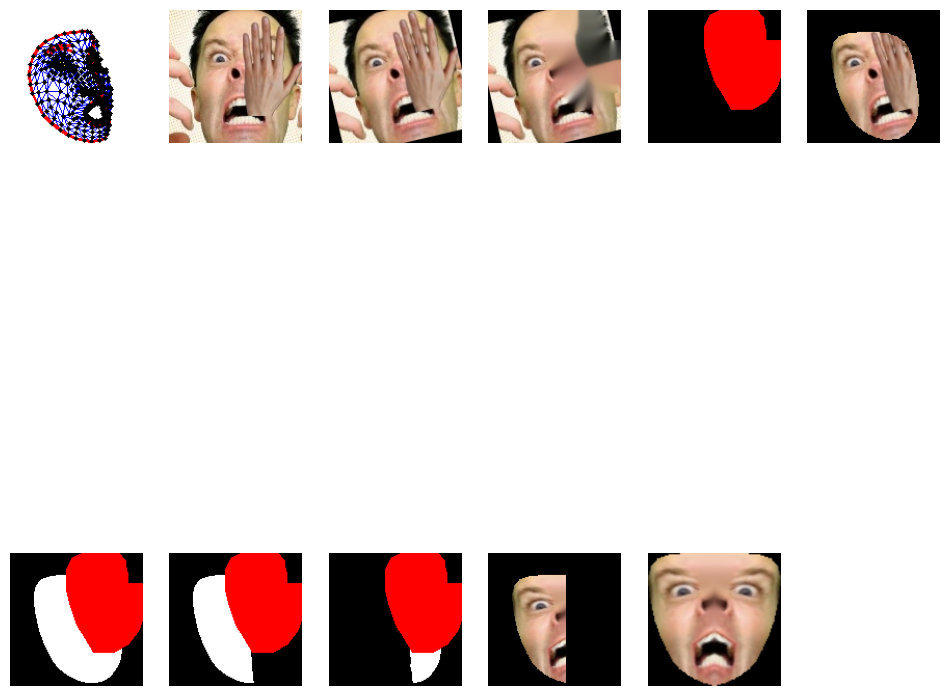

In [23]:
#img = 'images/img (6).jpg'
img = 'db_hand_rand/angry/angry_0911_hand.jpg'
flow, ori, output_image = half_flip(img)
show_images_grid(flow)
#show_img(output_image)

In [ ]:
from deepface import DeepFace
import pandas as pd

columns = ['img', 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral', 'emosi_dominan']

df_before = pd.DataFrame(columns=columns)
df_after = pd.DataFrame(columns=columns)

folder_path = 'uji'
for img_file in os.listdir(folder_path):
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img_ = os.path.join(folder_path, img_file)
    print('==============================')
    print(f"Memproses: {img_}")

    output_ = []
    
    flow, ori, output_image = half_flip(img_)
    path_ori = 'before/' + img_file
    path_out = 'after/' + img_file
    cv2.imwrite(path_ori, cv2.cvtColor(ori, cv2.COLOR_RGB2BGR))
    cv2.imwrite(path_out, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))
    
    output_.append((ori, None))            
    output_.append((output_image, None))
    
    show_images_grid_mini(output_)
   
    try:
        before = DeepFace.analyze(img_path=ori, actions=['emotion'])
        emo_before = before[0]['emotion']
        emo_b_angry = round(emo_before['angry'], 2)
        emo_b_disgust = round(emo_before['disgust'], 2)
        emo_b_fear = round(emo_before['fear'], 2)
        emo_b_happy = round(emo_before['happy'], 2)
        emo_b_sad = round(emo_before['sad'], 2)
        emo_b_surprise = round(emo_before['surprise'], 2)
        emo_b_neutral = round(emo_before['neutral'], 2)
        emotion_before = {'angry': emo_b_angry, 
                          'disgust': emo_b_disgust, 
                          'fear': emo_b_fear, 
                          'happy': emo_b_happy, 
                          'sad': emo_b_sad, 
                          'surprise': emo_b_surprise, 
                          'neutral': emo_b_neutral}
        emo_b_dominan = before[0]['dominant_emotion']
    except Exception as e:
        #print(f"Error pada proses 'before': {e}")
        emotion_before = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'sad': 0, 'surprise': 0, 'neutral': 0}
        emo_b_dominan = "gagal mendeteksi foto asli"

    new_data_b = {
        'img': img_,
        **emotion_before,
        'emosi_dominan': emo_b_dominan
    }
    df_before = pd.concat([df_before, pd.DataFrame([new_data_b])], ignore_index=True)
    
    try:
        after = DeepFace.analyze(img_path=output_image, actions=['emotion'])
        emo_after = after[0]['emotion']
        emo_a_angry = round(emo_after['angry'], 2)
        emo_a_disgust = round(emo_after['disgust'], 2)
        emo_a_fear = round(emo_after['fear'], 2)
        emo_a_happy = round(emo_after['happy'], 2)
        emo_a_sad = round(emo_after['sad'], 2)
        emo_a_surprise = round(emo_after['surprise'], 2)
        emo_a_neutral = round(emo_after['neutral'], 2)
        emotion_after = {'angry': emo_a_angry, 
                          'disgust': emo_a_disgust, 
                          'fear': emo_a_fear, 
                          'happy': emo_a_happy, 
                          'sad': emo_a_sad, 
                          'surprise': emo_a_surprise, 
                          'neutral': emo_a_neutral}
        emo_a_dominan = after[0]['dominant_emotion']
    except Exception as e:
        #print(f"Error pada proses 'after': {e}")
        emotion_after = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'sad': 0, 'surprise': 0, 'neutral': 0}
        emo_a_dominan = "gagal mendeteksi foto asli"

    new_data_a = {
        'img': img_,
        **emotion_after,
        'emosi_dominan': emo_a_dominan
    }
    df_after = pd.concat([df_after, pd.DataFrame([new_data_a])], ignore_index=True)
    
    print(f'emotion before: {emotion_before}')
    print(f'emotion after: {emotion_after}')

    print(f'emotion dominant before: {emo_b_dominan}')
    print(f'emotion dominant after: {emo_a_dominan}')

    
    #before_after(emotion_before, emotion_after, img_)
    
    print('==============================')
    print('\n')
    
    output_.clear()



In [ ]:
from feat import Detector

detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
)

detector

In [ ]:
import pandas as pd

columns = ['img', 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral', 'emosi_dominan']

df_before = pd.DataFrame(columns=columns)
df_after = pd.DataFrame(columns=columns)

folder_path = 'uji'
for img_file in os.listdir(folder_path):
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img_ = os.path.join(folder_path, img_file)
    print('==============================')
    print(f"Memproses: {img_}")

    output_ = []
    
    flow, ori, output_image = half_flip(img_)
    path_ori = 'before/' + img_file
    path_out = 'after/' + img_file
    
    cv2.imwrite(path_ori, cv2.cvtColor(ori, cv2.COLOR_RGB2BGR))
    cv2.imwrite(path_out, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))
    
    output_.append((ori, None))            
    output_.append((output_image, None))
    
    show_images_grid_mini(output_)

    try:
        before = detector.detect_image(path_ori)
        emo_before = before.emotions
        emo_b_angry = round(emo_before['anger'].iloc[0], 4)
        emo_b_disgust = round(emo_before['disgust'].iloc[0], 4)
        emo_b_fear = round(emo_before['fear'].iloc[0], 4)
        emo_b_happy = round(emo_before['happiness'].iloc[0], 4)
        emo_b_sad = round(emo_before['sadness'].iloc[0], 4)
        emo_b_surprise = round(emo_before['surprise'].iloc[0], 4)
        emo_b_neutral = round(emo_before['neutral'].iloc[0], 4)
        emotion_before = {'angry': emo_b_angry, 
                          'disgust': emo_b_disgust, 
                          'fear': emo_b_fear, 
                          'happy': emo_b_happy, 
                          'sad': emo_b_sad, 
                          'surprise': emo_b_surprise, 
                          'neutral': emo_b_neutral}
        emo_b_dominan = emo_before.idxmax(axis=1).iloc[0]
    except Exception as e:
        #print(f"Error pada proses 'before': {e}")
        emotion_before = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'sad': 0, 'surprise': 0, 'neutral': 0}
        emo_b_dominan = "gagal mendeteksi foto asli"

    new_data_b = {
        'img': img_,
        **emotion_before,
        'emosi_dominan': emo_b_dominan
    }
    df_before = pd.concat([df_before, pd.DataFrame([new_data_b])], ignore_index=True)
    
    try:
        after = detector.detect_image(path_out)
        emo_after = after.emotions
        emo_a_angry = round(emo_after['anger'].iloc[0], 4)
        emo_a_disgust = round(emo_after['disgust'].iloc[0], 4)
        emo_a_fear = round(emo_after['fear'].iloc[0], 4)
        emo_a_happy = round(emo_after['happiness'].iloc[0], 4)
        emo_a_sad = round(emo_after['sadness'].iloc[0], 4)
        emo_a_surprise = round(emo_after['surprise'].iloc[0], 4)
        emo_a_neutral = round(emo_after['neutral'].iloc[0], 4)
        emotion_after = {'angry': emo_a_angry, 
                          'disgust': emo_a_disgust, 
                          'fear': emo_a_fear, 
                          'happy': emo_a_happy, 
                          'sad': emo_a_sad, 
                          'surprise': emo_a_surprise, 
                          'neutral': emo_a_neutral}
        emo_a_dominan = emo_after.idxmax(axis=1).iloc[0]
    except Exception as e:
        #print(f"Error pada proses 'after': {e}")
        emotion_after = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'sad': 0, 'surprise': 0, 'neutral': 0}
        emo_a_dominan = "gagal mendeteksi foto asli"

    new_data_a = {
        'img': img_,
        **emotion_after,
        'emosi_dominan': emo_a_dominan
    }
    df_after = pd.concat([df_after, pd.DataFrame([new_data_a])], ignore_index=True)
    
    print(f'emotion before: {emotion_before}')
    print(f'emotion after: {emotion_after}')

    print(f'emotion dominant before: {emo_b_dominan}')
    print(f'emotion dominant after: {emo_a_dominan}')

    
    #before_after(emotion_before, emotion_after, img_)
    
    print('==============================')
    print('\n')
    
    output_.clear()



In [ ]:
df_before

In [ ]:
df_after